In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate, GlobalAvgPool2D
from tensorflow.keras.models import Model

# pretrained model: ResNet50
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight


In [3]:
def parse_spectrogram_and_metadata(melspec_path, split_path, metadata_path):
    # Load mel spectrograms
    melspec_dict = np.load(melspec_path, allow_pickle=True).item()

    # Load split and label info
    split_df = pd.read_csv(split_path)
    split_df['key'] = split_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    split_df = split_df.set_index('key')

    # Load downsampled metadata
    meta_df = pd.read_csv(metadata_path)
    meta_df['key'] = meta_df['filename'].apply(lambda x: x.replace('.ogg', '').replace('/', '-'))
    meta_df = meta_df.set_index('key')

    X_img, X_meta, y, splits = [], [], [], []

    for key in meta_df.index:
        if key not in melspec_dict or key not in split_df.index:
            continue

        img = melspec_dict[key]
        info = split_df.loc[key]
        meta_row = meta_df.loc[key]

        metadata = np.array([
            float(meta_row['latitude']),
            float(meta_row['longitude']),
            float(meta_row['call']),
            float(meta_row['song/canto'])
        ], dtype=np.float32)

        X_img.append(img)
        X_meta.append(metadata)
        y.append(info['y_species_encoded'])
        splits.append(info['split'])

    return np.array(X_img), np.array(X_meta), np.array(y), np.array(splits)

In [4]:
def split_data(X_img, X_meta, y, splits):
    split_map = defaultdict(lambda: ([], [], []))

    for i, split in enumerate(splits):
        split_map[split][0].append(X_img[i])
        split_map[split][1].append(X_meta[i])
        split_map[split][2].append(y[i])

    def to_np(t): return tuple(map(np.array, t))
    return {k: to_np(v) for k, v in split_map.items()}

In [5]:
# data augmentation
def add_random_noise(mels, noise_factor=0.05):
    noise = noise_factor * np.random.randn(*mels.shape)
    return np.clip(mels + noise, 0.0, 1.0).astype(np.float32)

def time_mask(spec, max_width=8):
    t = np.random.randint(0, spec.shape[1] - max_width)
    width = np.random.randint(1, max_width)
    spec[:, t:t+width] = 0
    return spec

def freq_mask(spec, max_height=4):
    f = np.random.randint(0, spec.shape[0] - max_height)
    height = np.random.randint(1, max_height)
    spec[f:f+height, :] = 0
    return spec


def augment_spectrogram(spec):
    spec = add_random_noise(spec)
    spec = time_mask(spec)
    spec = freq_mask(spec)
    spec = spec.astype(np.float32)

    return spec

def image_augment(spec):
    spec = tf.image.random_brightness(spec, max_delta = .1)
    spec = tf.image.random_contrast(spec, .9, 1.1)

    return spec



In [ ]:
X_img, X_meta, y, splits = parse_spectrogram_and_metadata(
    melspec_path= "../data/32/birdclef2025_melspec_5sec_32_32.npy",
    split_path= "../data/work_df_w_split_info.csv",
    metadata_path="../data/downsampled_metadata.csv"
)

In [7]:
# resizing image for inceptionv3
IMG_SIZE = 224

In [8]:
def preprocess_spec(img):
    img = tf.cast(img, tf.float32)
    img = img[..., tf.newaxis] # to get (32, 32, 1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) #(224, 224, 1)
    img = tf.image.grayscale_to_rgb(img) # now (224, 224, 3)

    return img


In [9]:
def make_tf_dataset(X_img, X_meta, y, batch_size = 32, augment = False, shuffle = True):
    def map_fn(img, meta, label):
        if augment:
            # augment before resizing
            img = tf.numpy_function(augment_spectrogram, [img], tf.float32)
            img.set_shape([32, 32])

        img = preprocess_spec(img)

        # take out augmenting after resizing
        # if augment:
        #     img = image_augment(img)

        return({"image": img, "metadata": meta}, tf.one_hot(label, num_classes))
    
    ds = tf.data.Dataset.from_tensor_slices((X_img, X_meta, y))
    if shuffle:
        ds = ds.shuffle(buffer_size = len(X_img))
        if shuffle:
            ds = ds.shuffle(buffer_size = len(X_img))
        
    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size=batch_size).prefetch(tf.data.AUTOTUNE)


    return ds

In [26]:
def build_inception_model(img_shape, meta_features_num, num_classes,
                          fine_tune = False,
                          fine_tune_at = None):
    # image input
    img_input = Input(shape = img_shape, name = "image")

    base_model = InceptionV3(include_top=False, weights = 'imagenet', input_tensor=img_input)

     # Fine-tune setup
    if fine_tune:
        base_model.trainable = True
        if fine_tune_at:
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
    else:
        # freeze for initial training
        base_model.trainable = False

    x = GlobalAvgPool2D()(base_model.output)

    # metadata input
    meta_input = Input(shape = (meta_features_num, ), name = "metadata")
    m = Dense(64, activation = "relu")(meta_input)
    m = Dropout(.3)(m)

    # now combining cnn & metadata
    combined = Concatenate()([x, m])
    combined = Dense(128, activation = "relu")(combined)
    combined = Dropout(.4)(combined)

    # added for model2
    combined = Dense(64, activation = "relu")(combined)
    combeind = Dropout(.5)(combined)
    
    output = Dense(num_classes, activation = "softmax")(combined)

    model = Model(inputs = {"image": img_input, "metadata": meta_input}, outputs = output)

    # compile model
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])

    return model

In [11]:
# modified from Denvir's code

data_splits = split_data(X_img, X_meta, y, splits)

X_train_img, X_train_meta, y_train = data_splits['train']
X_val_img, X_val_meta, y_val = data_splits['val']
X_test_img, X_test_meta, y_test = data_splits['test']

# Omit adding channel dimension to spectrograms
# X_train_img = X_train_img[..., np.newaxis]  # becomes (259, 32, 32, 1)
# X_val_img = X_val_img[..., np.newaxis]
# X_test_img = X_test_img[..., np.newaxis]

X_train_img = X_train_img.astype(np.float32)
X_val_img = X_val_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

X_train_meta = X_train_meta.astype(np.float32)
X_val_meta = X_val_meta.astype(np.float32)
X_test_meta = X_test_meta.astype(np.float32)

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)
y_test = y_test.astype(np.int32)

print(X_train_img.shape)  # --> (N, 256, 256, 1)
print(X_train_meta.shape) # --> (N, 4)
print(y_train.shape)      # --> (N,)

(259, 32, 32)
(259, 4)
(259,)


In [12]:
num_classes = len(np.unique(y))
print(num_classes)

4


In [14]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
img_shape

(224, 224, 3)

In [15]:
meta_features_num = X_train_meta.shape[1]
meta_features_num

4

In [16]:
train_ds = make_tf_dataset(X_train_img, X_train_meta, y_train, augment=True, shuffle=True)
val_ds = make_tf_dataset(X_val_img, X_val_meta, y_val, augment=False, shuffle=False)
test_ds = make_tf_dataset(X_test_img, X_test_meta, y_test, augment=False, shuffle=False)

In [17]:
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

In [18]:
scaler = StandardScaler()
X_train_meta = scaler.fit_transform(X_train_meta)
X_val_meta = scaler.transform(X_val_meta)
X_test_meta = scaler.transform(X_test_meta)

In [19]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [21]:
model_base = build_inception_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [22]:
# train
model_base.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2835 - loss: 3.4685

9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.2864 - loss: 3.4275 - val_accuracy: 0.3014 - val_loss: 1.8689
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2279 - loss: 2.4797

9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.2314 - loss: 2.4424 - val_accuracy: 0.4110 - val_loss: 1.2472
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3825 - loss: 1.5613

9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.3856 - loss: 1.5498 - val_accuracy: 0.5342 - val_loss: 1.2220
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4142 - loss: 1.2757

9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.4137 - loss: 1.2753 - val_accuracy: 0.4521 - val_loss: 1.2153
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3894 - loss: 1.2170 - val_accuracy: 0.5342 - val_loss: 1.2256
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3477 - loss: 1.3046

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.3504 - loss: 1.3015 - val_accuracy: 0.4795 - val_loss: 1.2131
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3554 - loss: 1.3096

9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3581 - loss: 1.3065 - val_accuracy: 0.5342 - val_loss: 1.1723
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5050 - loss: 1.0703 - val_accuracy: 0.4110 - val_loss: 1.2326
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3578 - loss: 1.2955 - val_accuracy: 0.5068 - val_loss: 1.1917
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3899 - loss: 1.2734 - val_accuracy: 0.4521 - val_loss: 1.1843
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4560 - loss: 1.1639

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4560 - loss: 1.1622 - val_accuracy: 0.4932 - val_loss: 1.1719
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4585 - loss: 1.1798

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4586 - loss: 1.1792 - val_accuracy: 0.5616 - val_loss: 1.1711
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4690 - loss: 1.1449

9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4684 - loss: 1.1468 - val_accuracy: 0.5890 - val_loss: 1.1512
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4477 - loss: 1.1289 - val_accuracy: 0.5068 - val_loss: 1.1550
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4633 - loss: 1.1354 - val_accuracy: 0.5205 - val_loss: 1.1640
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4966 - loss: 1.1406 - val_accuracy: 0.4932 - val_loss: 1.1550
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4654 - loss: 1.1625

9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.4702 - loss: 1.1567 - val_accuracy: 0.5068 - val_loss: 1.1394
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5247 - loss: 1.0387 - val_accuracy: 0.5479 - val_loss: 1.1563
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5031 - loss: 1.0791 - val_accuracy: 0.5342 - val_loss: 1.1687
Epoch 20/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4933 - loss: 1.1788 - val_accuracy: 0.5205 - val_loss: 1.1700
Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4774 - loss: 1.1322 - val_accuracy: 0.4932 - val_loss: 1.1678
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4992 - loss: 1.1000 - val_accuracy: 0.5342 - val_loss: 1.1692
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4669 - loss: 1.1190 - val_accuracy: 0.5068 - val_loss: 1.1765
Epoch 24/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5087 - loss: 1.0616 - val_accuracy: 0.5068 - val_loss: 1.1664
Epoch 25/50


In [ ]:
test_loss, test_acc = model_base.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model_base.evaluate(val_ds)
print(f"validation loss: {val_loss:.4f}, validation accuracy: {val_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - accuracy: 0.5588 - loss: 0.9633
test loss: 0.90, test accuracy: 0.62
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 952ms/step - accuracy: 0.4722 - loss: 1.1517
validation loss: 0.9039, validation accuracy: 0.6176


In [24]:
# Get predicted class indices
y_pred_prob = model_base.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
              precision    recall  f1-score   support

           0       0.45      0.69      0.55        13
           1       1.00      0.06      0.12        16
           2       0.55      0.84      0.67        19
           3       0.89      0.80      0.84        20

    accuracy                           0.62        68
   macro avg       0.72      0.60      0.54        68
weighted avg       0.74      0.62      0.57        68



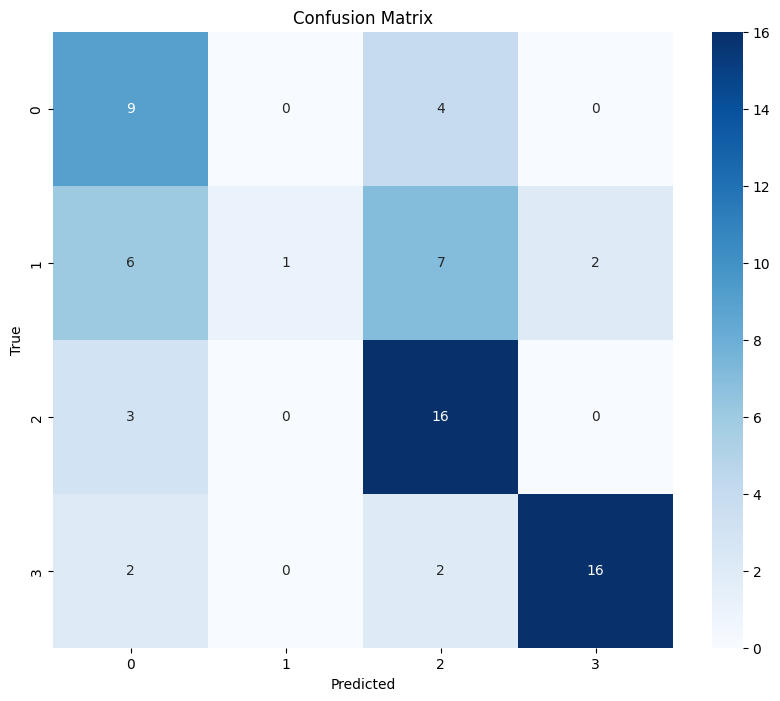

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
model2 = build_inception_model(img_shape=img_shape,
                              meta_features_num=meta_features_num,
                              num_classes=num_classes)

In [28]:
model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 50,
    callbacks = callbacks,
    verbose = 1    
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.2374 - loss: 2.5924 - val_accuracy: 0.4384 - val_loss: 1.2855
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3527 - loss: 1.4456 - val_accuracy: 0.4247 - val_loss: 1.2527
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3642 - loss: 1.4481 - val_accuracy: 0.4384 - val_loss: 1.1997
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3315 - loss: 1.3159 - val_accuracy: 0.4521 - val_loss: 1.1664
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3720 - loss: 1.3302 - val_accuracy: 0.4521 - val_loss: 1.1886
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4070 - loss: 1.3535 - val_accuracy: 0.4521 - val_loss: 1.1626
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3780 - loss: 1.2809 - val_accuracy: 0.5205 - val_loss: 1.1426
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4238 - loss: 1.1936 - val_accuracy: 0.4795 - val_loss: 1.1620
Epoch 9/

In [29]:
test_loss, test_acc = model2.evaluate(test_ds)
print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}")

val_loss, val_acc = model2.evaluate(val_ds)
print(f"validation loss: {test_loss:.4f}, validation accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 912ms/step - accuracy: 0.4972 - loss: 1.1097
test loss: 1.01, test accuracy: 0.59
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.4439 - loss: 1.2231
validation loss: 1.0089, validation accuracy: 0.5882


In [30]:
# Get predicted class indices
y_pred_prob = model2.predict(test_ds)
y_pred = y_pred_prob.argmax(axis=1)

# Print classification report
print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        13
           1       1.00      0.19      0.32        16
           2       0.49      0.95      0.64        19
           3       0.80      0.80      0.80        20

    accuracy                           0.59        68
   macro avg       0.67      0.54      0.51        68
weighted avg       0.68      0.59      0.54        68



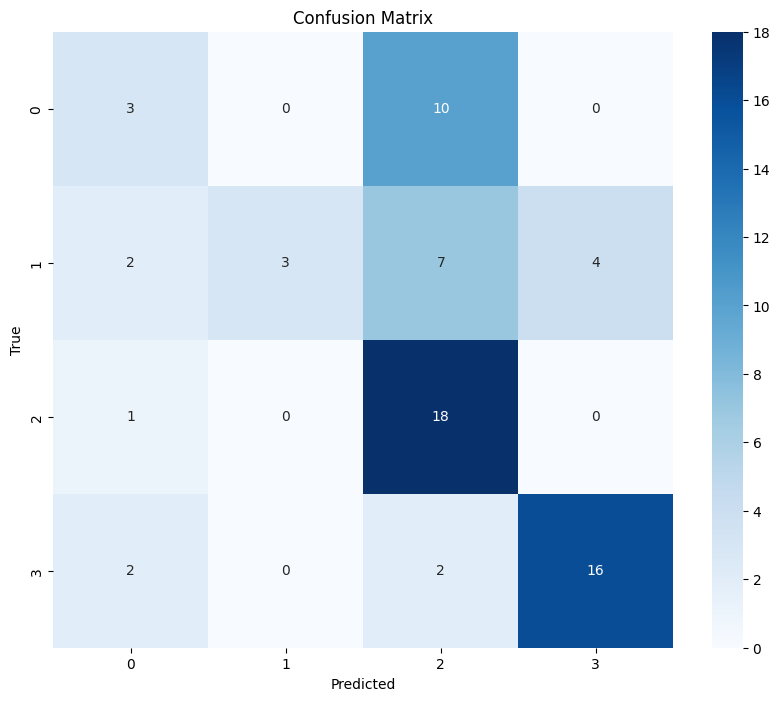

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()